### **Imports, Constants and Configurations:**

In [1]:
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from utilities.utils import move_to_front

In [2]:
CON_CMAP = sns.cubehelix_palette(start=-1.3, rot=.7, as_cmap=True)
def DIS_CMAP(bins=30, r=False):
    if r: return list(reversed([CON_CMAP(i) for i in np.linspace(0, 1, bins)]))
    else: return [CON_CMAP(i) for i in np.linspace(0, 1, bins)]
DIV_CMAP = mcolors.LinearSegmentedColormap.from_list(
    "mirrored_cmap",
    colors=np.concatenate((CON_CMAP(np.linspace(0, 1, 128)),
                           CON_CMAP(np.linspace(1, 0, 128)))))
NUMERICAL_COLS = [
    'budget', 'popularity', 'runtime', 'vote_average',
    'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
    'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
    'language_code', 'status_code', 'year', 'month', 'day', 'actor_1_code',
    'actor_2_code', 'actor_3_code', 'actor_4_code', 'actor_5_code', 'production_company_code',
]
CREW_COLS = [
    'actor_1_code', 'actor_2_code', 'actor_3_code',
    'actor_4_code', 'actor_5_code', 'production_company_code',
]
GENRE_COLS = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
    'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]
# Numerical features that are not a genre or crew code
NON_GENRE_COLS = move_to_front(list(set(NUMERICAL_COLS) - set(GENRE_COLS) - set(CREW_COLS)), 'revenue')

In [3]:
warnings.filterwarnings('ignore')

### **Loading Data:**

In [4]:
movie_df = pd.read_csv("./data/movies_data.csv").rename(columns={'Unnamed: 0': 'ID'})

movie_df['original_language'] = movie_df['original_language'].astype('category')
movie_df['status'] = movie_df['status'].astype('category')
movie_df['actor_name_1'] = movie_df['actor_name_1'].astype('category')
movie_df['actor_name_2'] = movie_df['actor_name_2'].astype('category')
movie_df['actor_name_3'] = movie_df['actor_name_3'].astype('category')
movie_df['actor_name_4'] = movie_df['actor_name_4'].astype('category')
movie_df['actor_name_5'] = movie_df['actor_name_5'].astype('category')
movie_df['production_company_name'] = movie_df['production_company_name'].astype('category')

movie_df['revenue_millions'] = movie_df['revenue'] / 1.0e6
movie_df['budget_millions'] = movie_df['budget'] / 1.0e6


movie_df

,ID,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,...,actor_4_code,actor_5_code,production_company_code,year,month,day,binned_revenue,profit_rate,revenue_millions,budget_millions
0,0,Four Rooms,4000000,"[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...",en,22.876230,1995-12-09,4300000,98.0,Released,...,2006,1988,765,1995,12,9,0,1.075000,4.300000,4.0000
1,1,American Beauty,15000000,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...",en,80.878605,1999-09-15,356296601,122.0,Released,...,3146,2092,341,1999,9,15,16,23.753107,356.296601,15.0000
2,2,Dancer in the Dark,12800000,"[{'id': 30, 'name': 'individual'}, {'id': 246,...",en,22.022228,2000-05-17,40031879,140.0,Released,...,2487,1504,430,2000,5,17,1,3.127491,40.031879,12.8000
3,3,The Fifth Element,90000000,"[{'id': 402, 'name': 'clone'}, {'id': 444, 'na...",en,109.528572,1997-05-07,263920180,126.0,Released,...,2261,541,254,1997,5,7,12,2.932446,263.920180,90.0000
4,4,Metropolis,92620000,"[{'id': 312, 'name': 'man vs machine'}, {'id':...",de,32.351527,1927-01-10,650422,153.0,Released,...,2715,1035,868,1927,1,10,0,0.007022,0.650422,92.6200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,4517,Restoration,0,[],en,2.525569,2016-05-03,0,90.0,Released,...,2771,0,0,2016,5,3,0,0.000000,0.000000,0.0000
4518,4518,Operation Chromite,0,"[{'id': 10586, 'name': 'korea'}, {'id': 229851...",ko,6.116436,2016-07-27,0,110.0,Released,...,1507,1649,1098,2016,7,27,0,0.000000,0.000000,0.0000
4519,4519,Perfect Cowboy,200,[],en,0.050978,2014-07-13,0,109.0,Released,...,2832,0,0,2014,7,13,0,0.000000,0.000000,0.0002
4520,4520,Puss in Boots,130000000,"[{'id': 4414, 'name': 'adventure'}, {'id': 618...",en,20.678787,2011-10-28,554987477,90.0,Released,...,340,139,339,2011,10,28,25,4.269134,554.987477,130.0000


In [5]:
movie_df.columns

Index(['ID', 'title', 'budget', 'keywords', 'original_language', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'vote_average',
       'vote_count', 'actor_name_1', 'actor_name_2', 'actor_name_3',
       'actor_name_4', 'actor_name_5', 'production_company_name', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'language_code', 'status_code', 'actor_1_code', 'actor_2_code',
       'actor_3_code', 'actor_4_code', 'actor_5_code',
       'production_company_code', 'year', 'month', 'day', 'binned_revenue',
       'profit_rate', 'revenue_millions', 'budget_millions'],
      dtype='object')

### **Basic Exploration:**

#### Genre Variability:

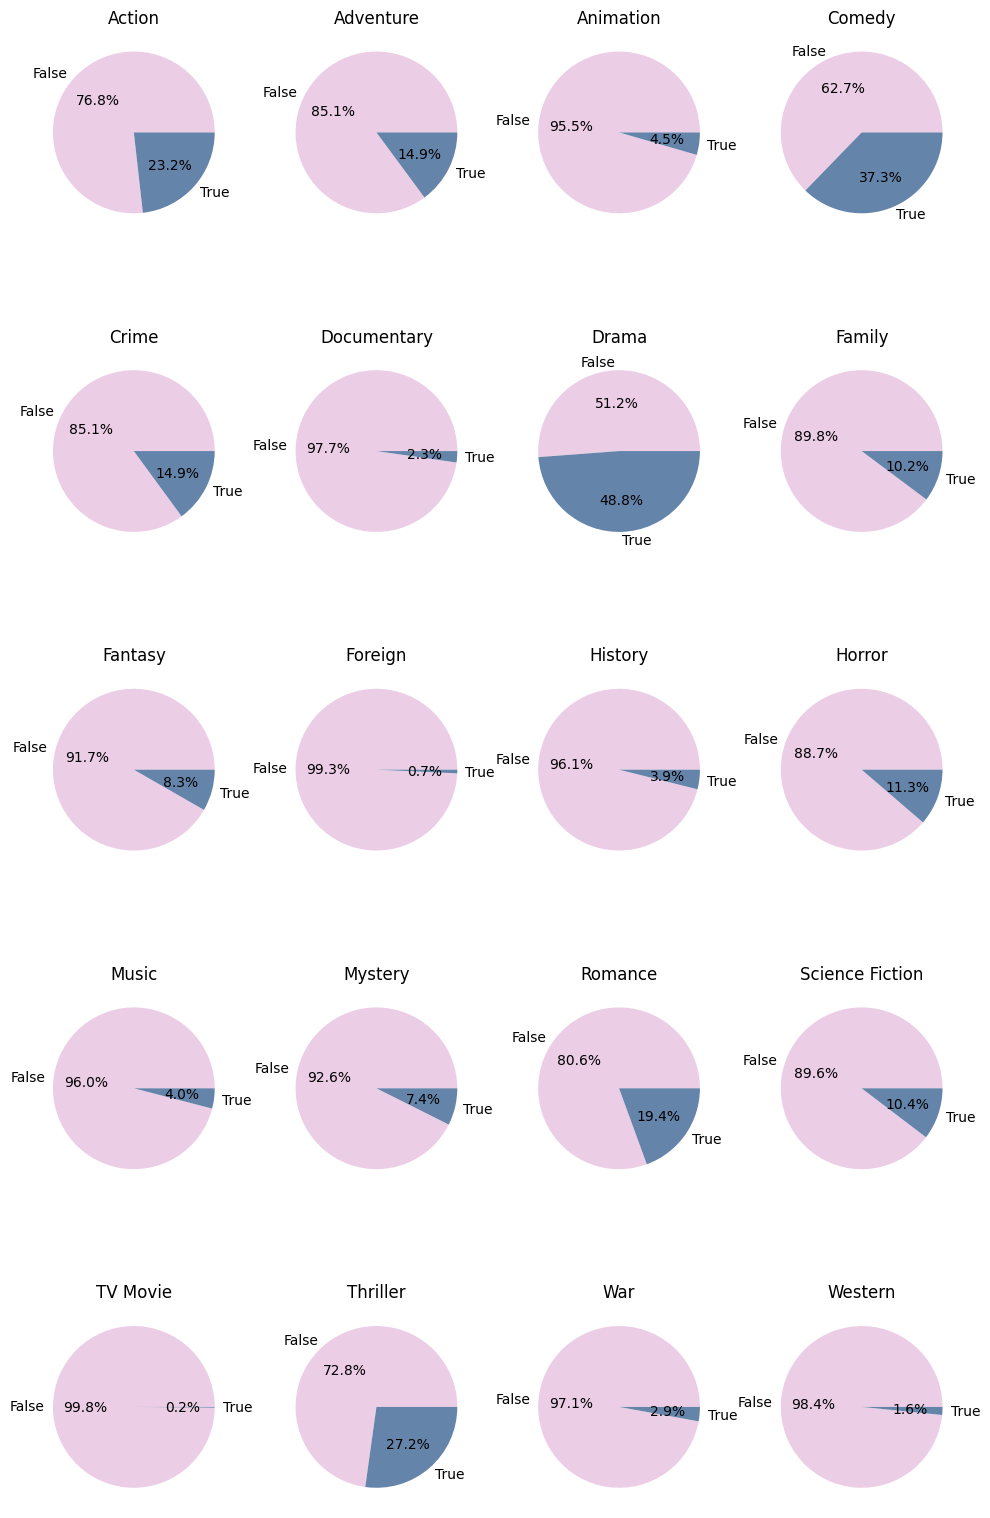

In [6]:
fig, axs = plt.subplots(5, 4, figsize=(12, 20))

for i, col in enumerate(GENRE_COLS):
    ax = axs[i//4, i%4]
    counts = movie_df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=DIS_CMAP(3))
    ax.set_title(col)

#### Status:

Text(0.5, 1.0, 'Status')

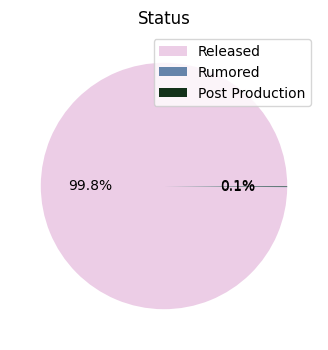

In [7]:
plt.figure(figsize=(4, 4))
counts = movie_df['status'].value_counts()
plt.pie(counts, autopct='%1.1f%%', colors=DIS_CMAP(3))
plt.legend(labels=counts.index, loc='best') 
plt.title('Status')

#### Numerical Features:

##### **1. Budget:**

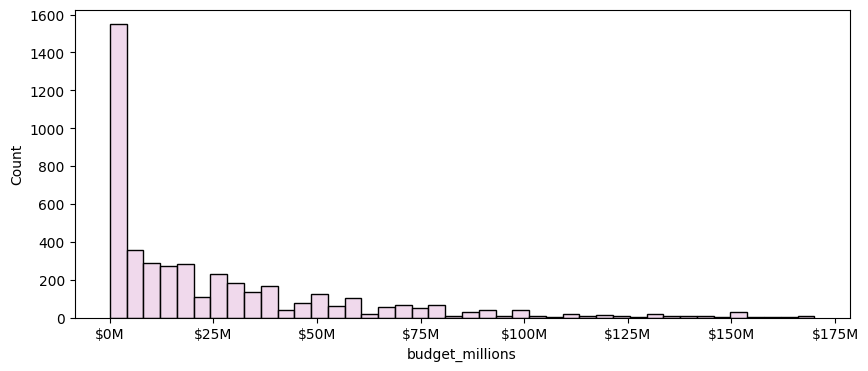

In [8]:
# Plot the histogram
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='budget_millions', color=DIS_CMAP(5)[0])

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

##### **2. Popularity:**

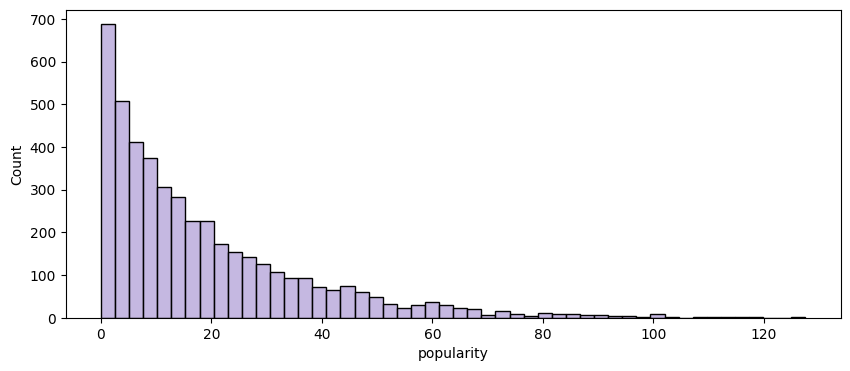

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='popularity', color=DIS_CMAP(5)[1])

plt.show()

##### **3. Revenue:**

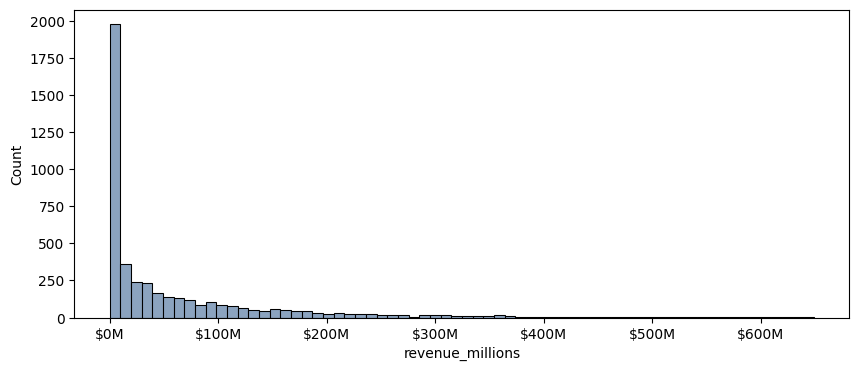

In [10]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='revenue_millions', color=DIS_CMAP(5)[2])

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

##### **4. Runtime:**

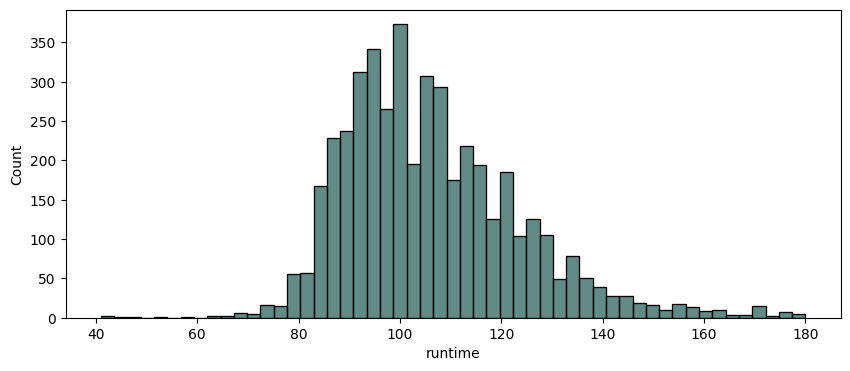

In [11]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='runtime', color=DIS_CMAP(5)[3])

plt.show()

##### **5. Rating:**

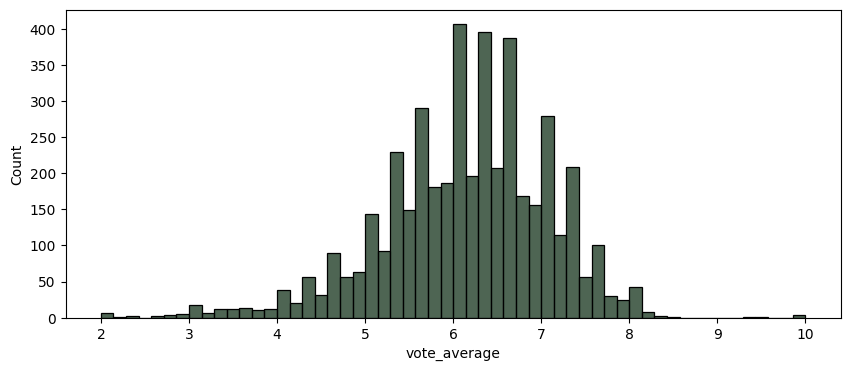

In [12]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='vote_average', color=DIS_CMAP(5)[4])

plt.show()

#### Number of Movies in Each Genre:

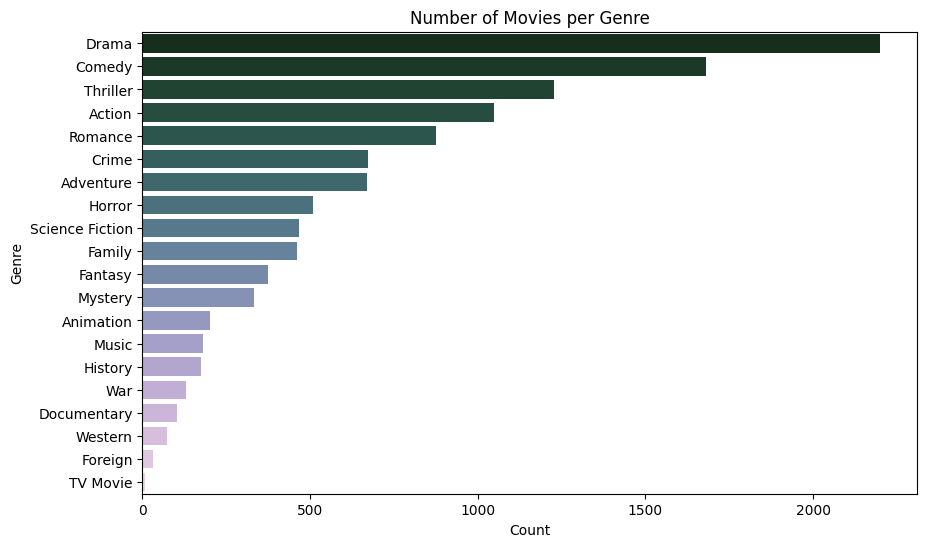

In [13]:
genre_counts = movie_df[GENRE_COLS].sum().reset_index()
genre_counts.columns = ['Genre', 'Count']
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Genre', data=genre_counts, palette=DIS_CMAP(20, True))
plt.title('Number of Movies per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

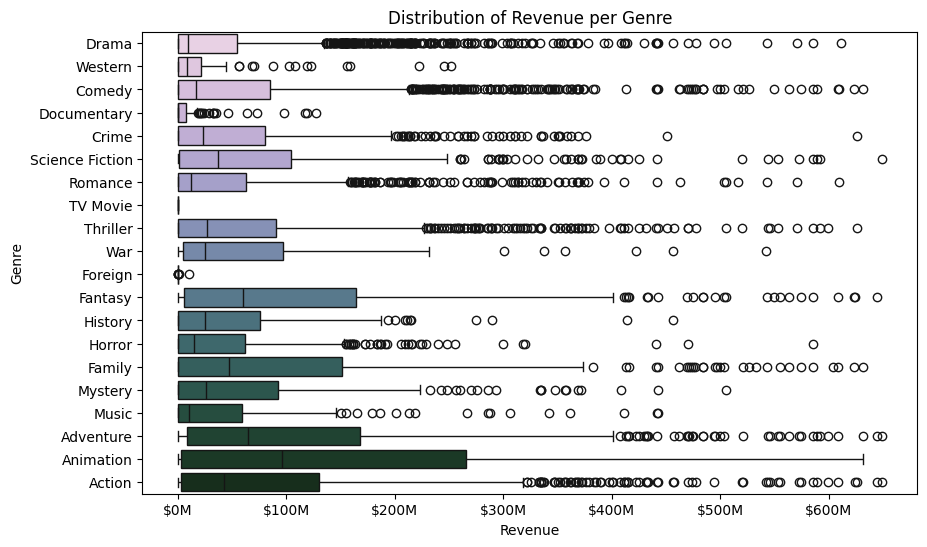

In [14]:
movie_df[GENRE_COLS] = movie_df[GENRE_COLS].fillna(False)
melted_df = movie_df.melt(id_vars='revenue_millions', value_vars=GENRE_COLS, var_name='Genre')
melted_df = melted_df[melted_df['value']].sort_values('revenue_millions')

plt.figure(figsize=(10, 6))
sns.boxplot(x='revenue_millions', y='Genre', data=melted_df, palette=DIS_CMAP(20))
plt.title('Distribution of Revenue per Genre')
plt.xlabel('Revenue')
plt.ylabel('Genre')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

### **Feature Correlations and Importance:**

#### Correlation between genres and revenue:

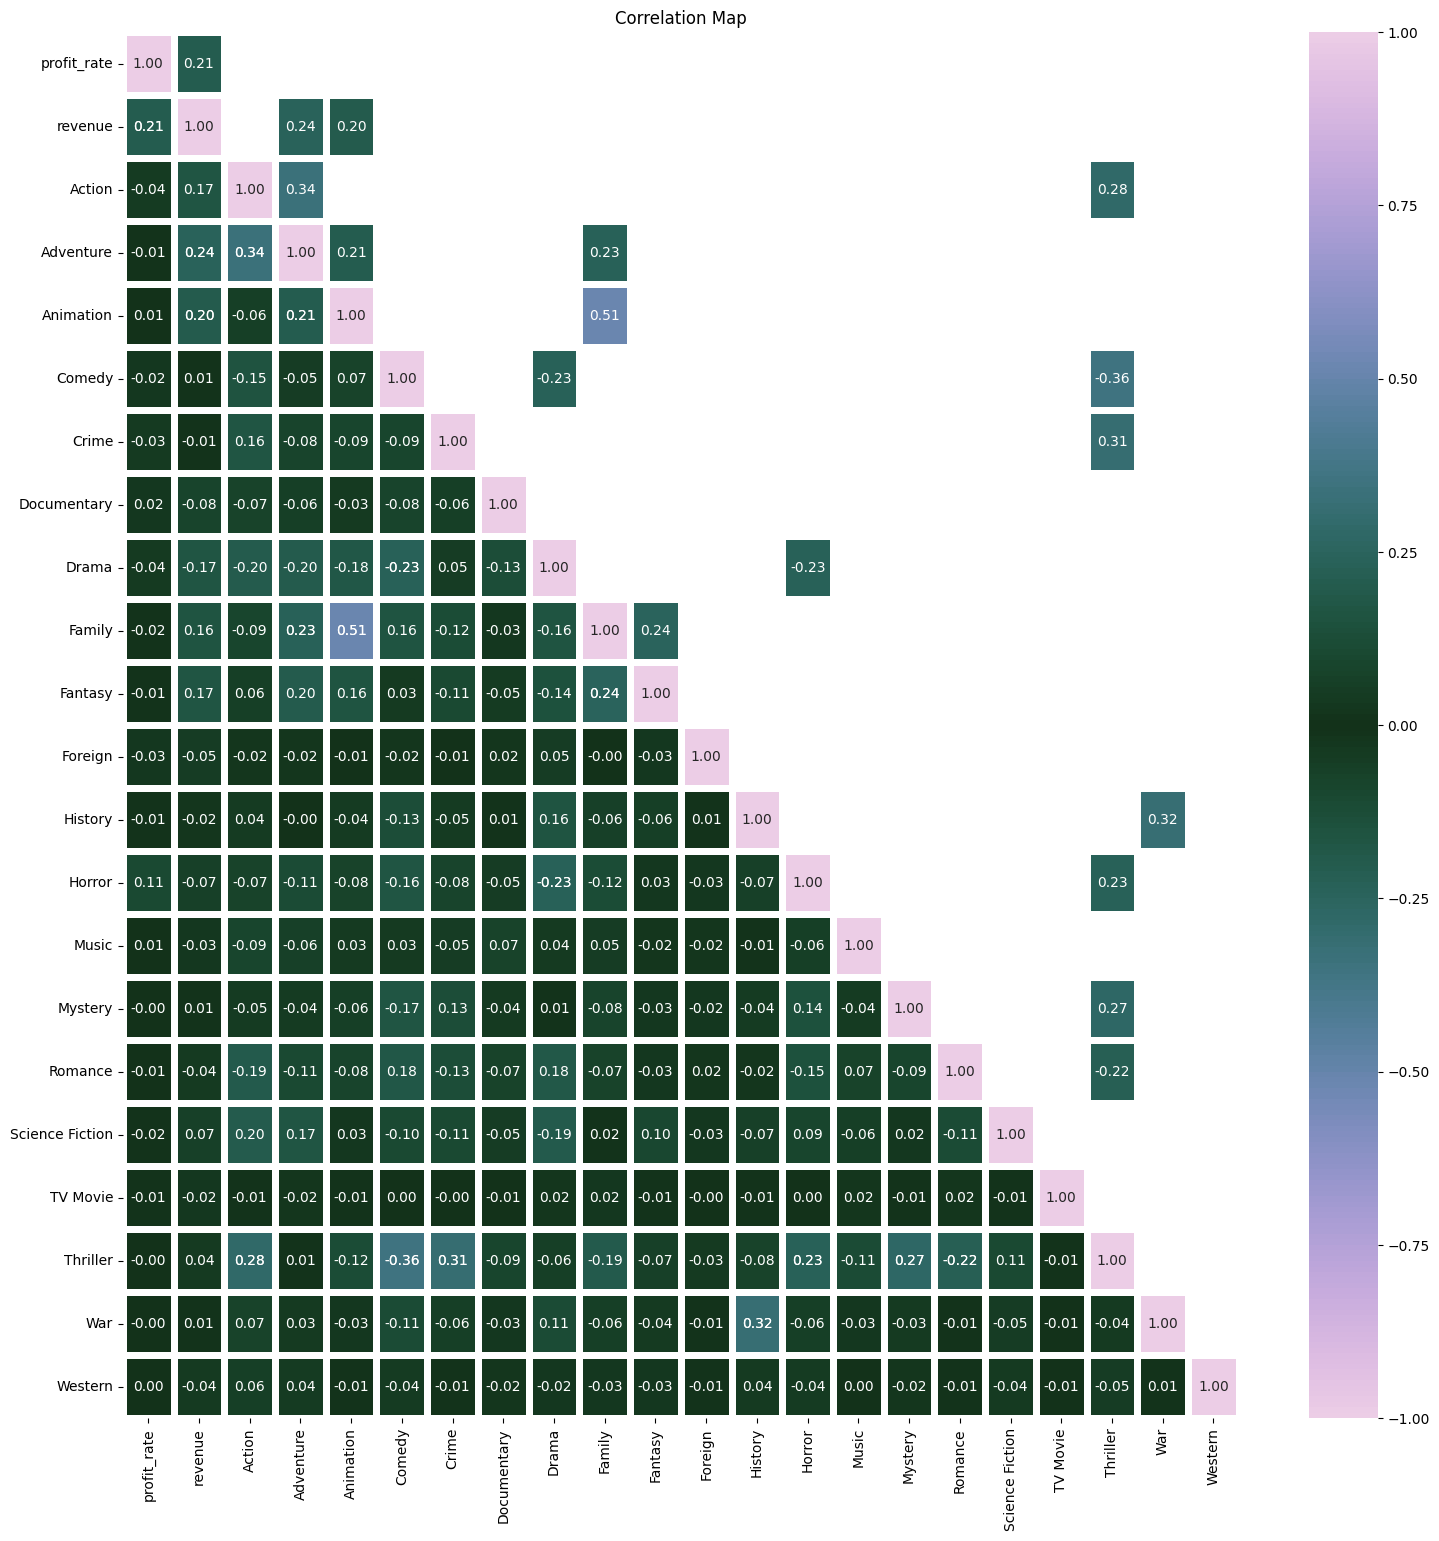

In [15]:
plt.figure(figsize=(18, 18))
genre_rev = ['profit_rate', 'revenue'] + GENRE_COLS
corr_df = movie_df[genre_rev]
corr = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

plt.title('Correlation Map')
plt.show()

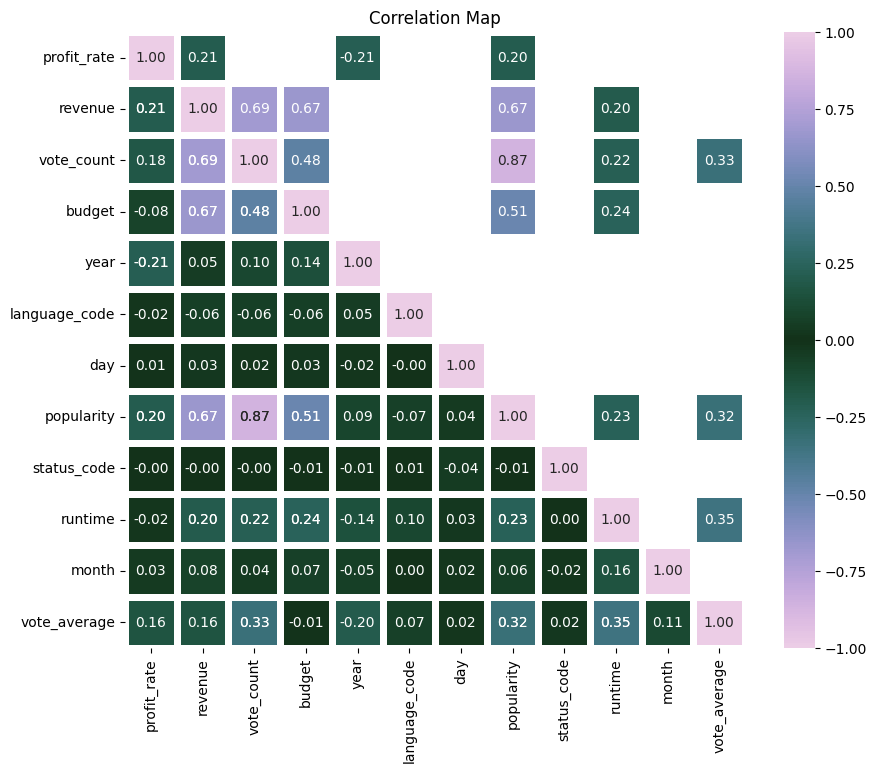

In [16]:
plt.figure(figsize=(10, 8))

genre_rev = ['profit_rate', 'revenue'] + NON_GENRE_COLS
corr_df = movie_df[genre_rev]
corr = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

plt.title('Correlation Map')
plt.show()

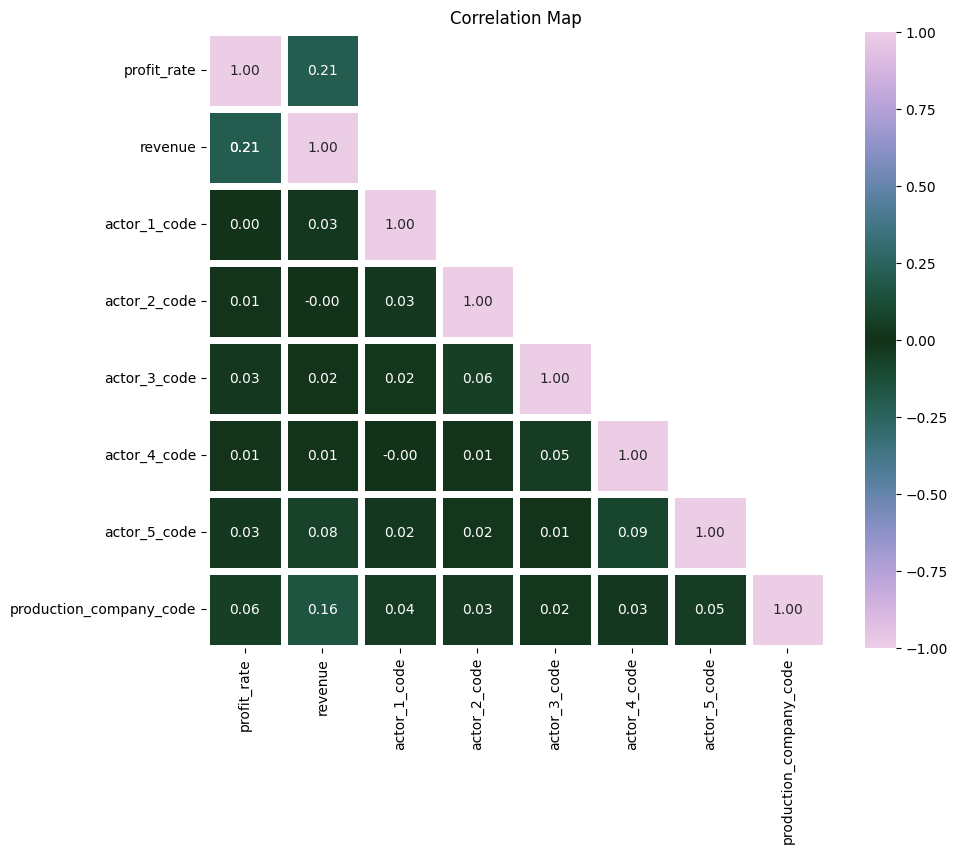

In [17]:
plt.figure(figsize=(10, 8))

crew_rev = ['profit_rate', 'revenue'] + CREW_COLS
corr_df = movie_df[crew_rev]
corr = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

plt.title('Correlation Map')
plt.show()

#### Feature Importance:

In [18]:
x = movie_df[NUMERICAL_COLS].astype('category')
y = movie_df['binned_revenue']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report_str)

Accuracy: 0.54

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       481
           1       0.13      0.09      0.11        98
           2       0.08      0.06      0.07        62
           3       0.08      0.04      0.05        52
           4       0.16      0.14      0.15        43
           5       0.25      0.10      0.14        41
           6       0.00      0.00      0.00        10
           7       0.08      0.11      0.09        19
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        14
          10       0.50      0.09      0.15        11
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         7
          13       0.50      0.17      0.25         6
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         3
          16       0.50      0.12      0.2

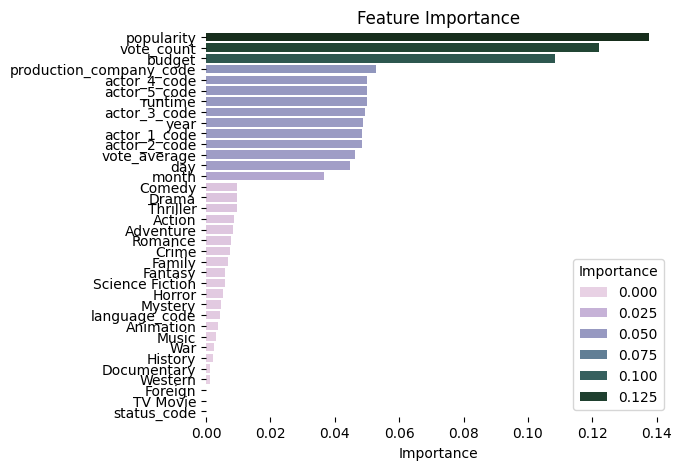

In [20]:
feature_importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=CON_CMAP, hue="Importance")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

### **Exploratory Data Analysis:**

#### Popularity:

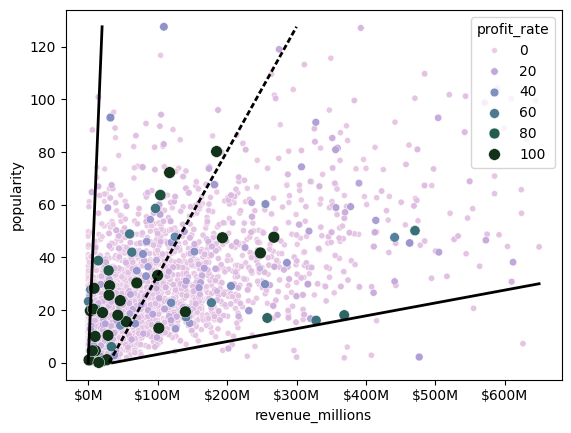

In [21]:
temp_df = movie_df.sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='revenue_millions', y='popularity',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

ax.plot([temp_df['revenue_millions'].min()+30, 300], [0, temp_df['popularity'].max()], color='black', linewidth=2, linestyle=(0, (2, 1)))
ax.plot([temp_df['revenue_millions'].min(), 20], [0, temp_df['popularity'].max()], color='black', linewidth=2)
ax.plot([temp_df['revenue_millions'].min()+35, temp_df['revenue_millions'].max()], [0, 30], color='black', linewidth=2)

plt.show()

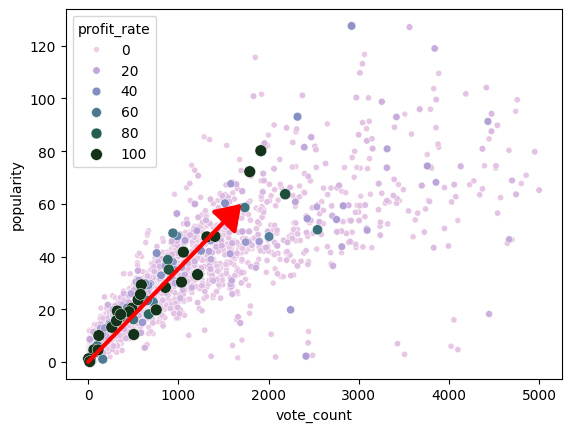

In [22]:
temp_df = movie_df.sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='vote_count', y='popularity',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

prop = dict(arrowstyle="-|>,head_width=1,head_length=1.5",
            shrinkA=0, shrinkB=0, linewidth=3, facecolor='red', edgecolor='red')
plt.annotate("", xy=(1700,60), xytext=(0,0), arrowprops=prop)
ax = plt.gca()

plt.show()


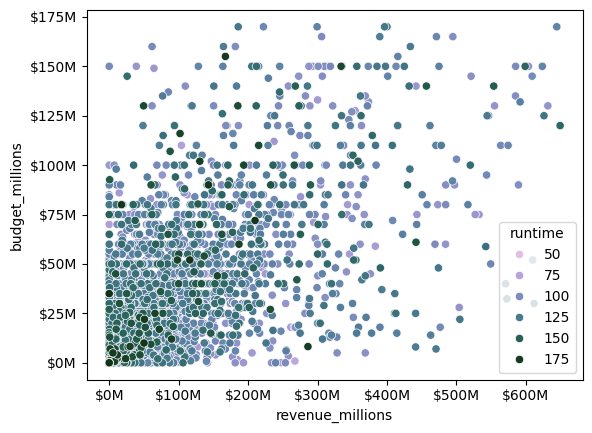

In [23]:
temp_df = movie_df.sort_values('runtime', ascending=True)

sns.scatterplot(data=temp_df, x='revenue_millions', y='budget_millions',
                palette=CON_CMAP, hue='runtime')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

plt.show()

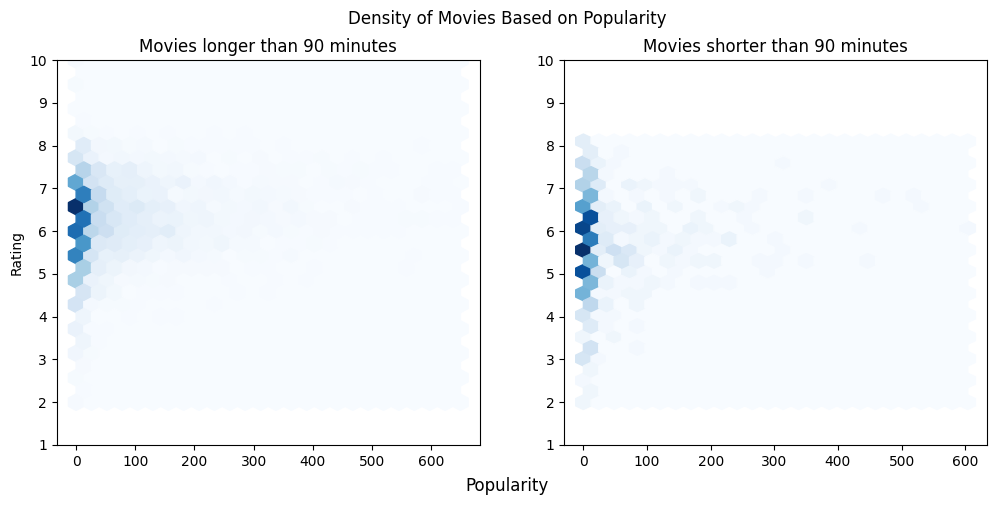

In [24]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("Density of Movies Based on Popularity")
fig.supxlabel("Popularity")

axs[0].set_ylabel("Rating")
axs[0].set_title('Movies longer than 90 minutes')
axs[1].set_title('Movies shorter than 90 minutes')

temp1_df = movie_df[movie_df['runtime'] > 90]
temp2_df = movie_df[movie_df['runtime'] < 90]

hb = axs[0].hexbin(temp1_df['revenue_millions'], temp1_df['vote_average'], gridsize=25, cmap=sns.color_palette("Blues", as_cmap=True))
hb = axs[1].hexbin(temp2_df['revenue_millions'], temp2_df['vote_average'], gridsize=(25, 12), cmap=sns.color_palette("Blues", as_cmap=True))

axs[0].set_ylim([1, 10])
axs[1].set_ylim([1, 10])

plt.show()

   decade  budget_millions
0    1920        23.311000
1    1930         1.152369
2    1940         1.837280
3    1950         2.690132
4    1960         3.987904
5    1970         6.845997
6    1980        12.706819
7    1990        27.970926
8    2000        27.277173
9    2010        25.980002


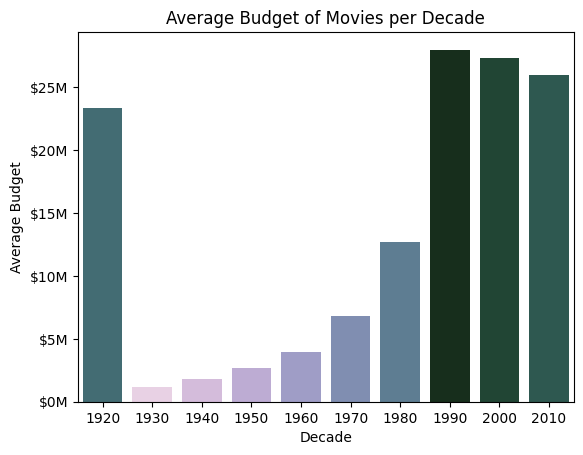

In [25]:
temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_budget_millions_per_decade = temp_df.groupby('decade')['budget_millions'].mean().reset_index()
print(average_budget_millions_per_decade)

sns.barplot(x='decade', y='budget_millions', data=average_budget_millions_per_decade, palette=DIS_CMAP(10), hue='budget_millions')

plt.title('Average Budget of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Budget')
plt.legend().remove()

ax = plt.gca()
yformatter = ticker.FormatStrFormatter('$%1.0fM')
ax.yaxis.set_major_formatter(yformatter)

plt.show()

   decade  revenue_millions
0    1920          6.752105
1    1930         19.366613
2    1940         23.710031
3    1950         14.756551
4    1960         30.399248
5    1970         51.841583
6    1980         56.372550
7    1990         68.190243
8    2000         59.554230
9    2010         65.667673


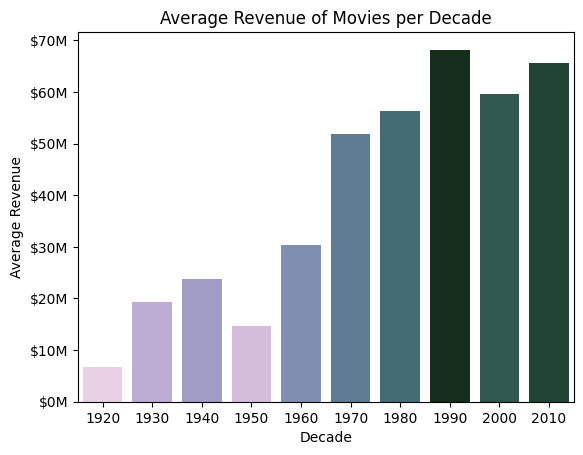

In [26]:
temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_revenue_millions_per_decade = temp_df.groupby('decade')['revenue_millions'].mean().reset_index()
print(average_revenue_millions_per_decade)
sns.barplot(x='decade', y='revenue_millions', data=average_revenue_millions_per_decade, palette=DIS_CMAP(10), hue='revenue_millions')

plt.title('Average Revenue of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Revenue')
plt.legend().remove()

ax = plt.gca()
yformatter = ticker.FormatStrFormatter('$%1.0fM')
ax.yaxis.set_major_formatter(yformatter)

plt.show()

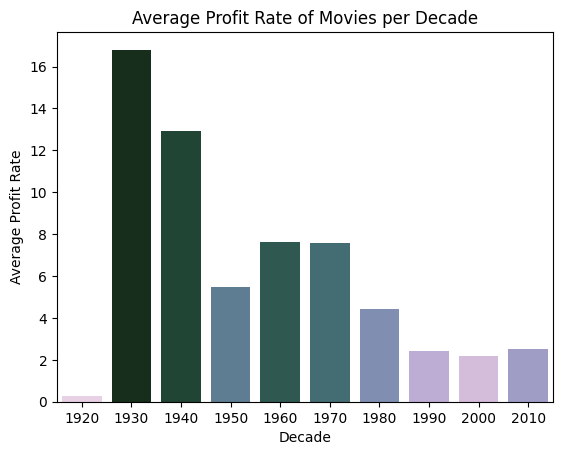

In [32]:
temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_ratio_per_decade = average_revenue_millions_per_decade.copy()
average_ratio_per_decade['revenue_budget_ratio'] = average_revenue_millions_per_decade['revenue_millions'] \
    / average_budget_millions_per_decade['budget_millions']

sns.barplot(x='decade', y='revenue_budget_ratio', data=average_ratio_per_decade, palette=DIS_CMAP(10), hue='revenue_budget_ratio')

plt.title('Average Profit Rate of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Profit Rate')
plt.legend().remove()

plt.show()

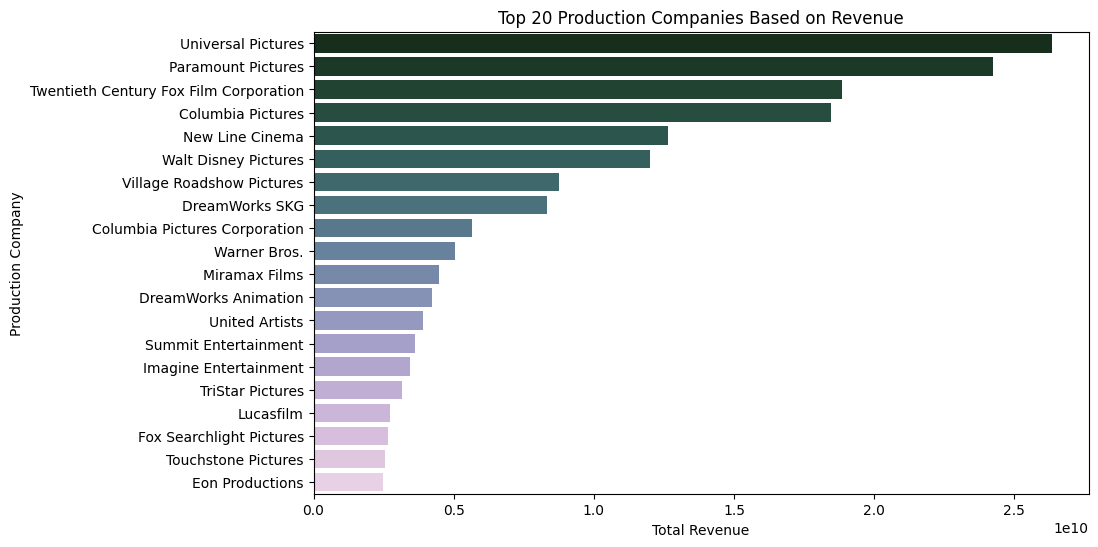

In [28]:
grouped_df = movie_df.groupby('production_company_name')['revenue'].sum().reset_index()

top_20_prod_companies = grouped_df.sort_values(by='revenue', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='revenue', y='production_company_name', data=top_20_prod_companies,
            palette=DIS_CMAP(20, True), order=top_20_prod_companies['production_company_name'])

plt.xlabel('Total Revenue')
plt.ylabel('Production Company')
plt.title('Top 20 Production Companies Based on Revenue')
plt.show()


In [29]:
actor_columns = ['actor_name_1', 'actor_name_2', 'actor_name_3', 'actor_name_4', 'actor_name_5']
all_actors = movie_df[actor_columns].values.flatten()

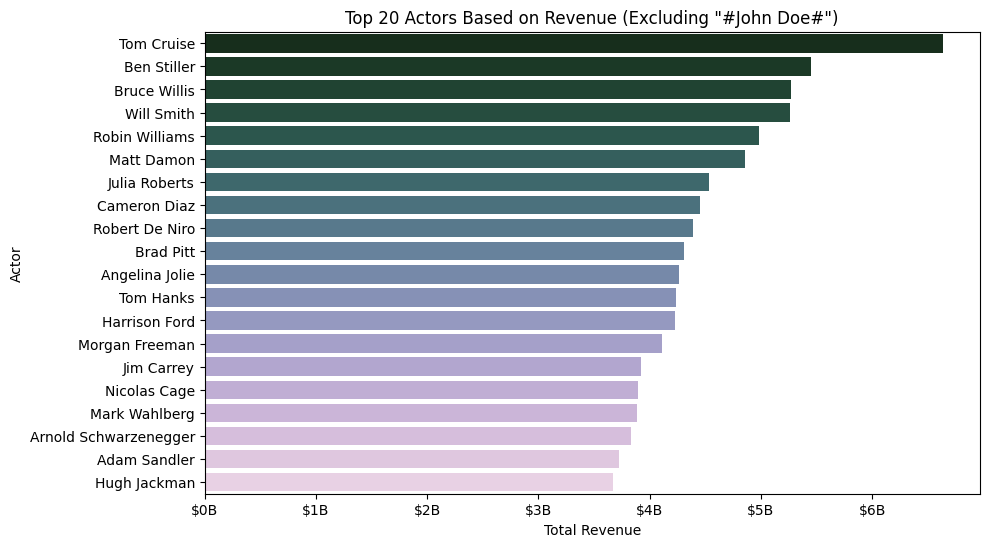

In [30]:
actor_df = pd.DataFrame({'actor_name': all_actors, 'revenue': np.repeat(movie_df['revenue'].values, 5)})

grouped_actor_df = actor_df.groupby('actor_name')['revenue'].sum().reset_index()

grouped_actor_df = grouped_actor_df[grouped_actor_df['actor_name'] != "#John Doe#"]

top_20_actors = grouped_actor_df.sort_values(by='revenue', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='revenue', y='actor_name', data=top_20_actors,
            palette=DIS_CMAP(20, True), order=top_20_actors['actor_name'])

xlabels = ['${:,.0f}B'.format(x) for x in plt.gca().get_xticks()/1e9]
plt.gca().set_xticklabels(xlabels)

plt.xlabel('Total Revenue')
plt.ylabel('Actor')
plt.title('Top 20 Actors Based on Revenue (Excluding "#John Doe#")')
plt.show()


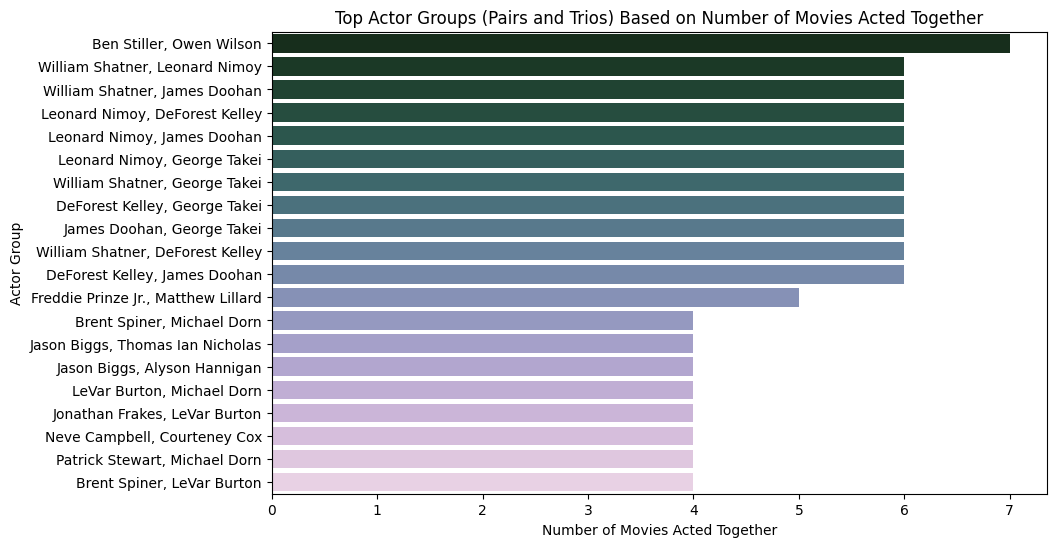

In [31]:
actor_df = pd.DataFrame({
    'actor_name': all_actors, 
    'movie_id': np.repeat(movie_df['ID'].values, 5)
})

actor_df = actor_df[actor_df['actor_name'] != "#John Doe#"]
actor_trios = [list(itertools.combinations(actors, 3)) for actors in grouped_actor_df]

actor_trios = [trio for sublist in actor_trios for trio in sublist]
trio_counts = collections.Counter(actor_trios)

trio_df = pd.DataFrame(trio_counts.items(), columns=['actor_group', 'count'])
trio_df['actor_group'] = trio_df['actor_group'].apply(lambda x: ', '.join(x))

top_20_trios = trio_df.sort_values(by='count', ascending=False).head(20)

actors_in_top_trios = set(itertools.chain.from_iterable(top_20_trios['actor_group'].str.split(', ')))
actor_df = actor_df[~actor_df['actor_name'].isin(actors_in_top_trios)]

actor_pairs = [list(itertools.combinations(actors, 2)) for actors in actor_df.groupby('movie_id')['actor_name'].apply(list)]
actor_pairs = [pair for sublist in actor_pairs for pair in sublist]
pair_counts = collections.Counter(actor_pairs)

pair_df = pd.DataFrame(pair_counts.items(), columns=['actor_group', 'count'])
pair_df['actor_group'] = pair_df['actor_group'].apply(lambda x: ', '.join(x))

top_20_pairs = pair_df.sort_values(by='count', ascending=False).head(20)
top_groups = pd.concat([top_20_trios, top_20_pairs]).sort_values('count', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='actor_group', data=top_groups,
            palette=DIS_CMAP(20, True), order=top_groups['actor_group'])

plt.xlabel('Number of Movies Acted Together')
plt.ylabel('Actor Group')
plt.title('Top Actor Groups (Pairs and Trios) Based on Number of Movies Acted Together')
plt.show()
